In [ ]:
!pip install pickle5
!pip install --upgrade pandas

In [1]:
import os
import pickle5 as pickle
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print(f'tensorflow version: {tf.version.VERSION}')

tensorflow version: 2.7.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# set seed, debugging and assign GPU

tf.random.set_seed(50)
tf.debugging.set_log_device_placement(False)

tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# import data

with open('/content/drive/MyDrive/Thesis/usa_classified_tweets.pkl', 'rb') as pickle_in:
  df = pickle.load(pickle_in)
  pickle_in.close()

In [5]:
df['believer_denier'].value_counts()

1    100749
0     52196
Name: believer_denier, dtype: int64

In [6]:
df.shape

(152945, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152945 entries, 0 to 152944
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   152945 non-null  int64  
 1   text                 152945 non-null  object 
 2   location             152945 non-null  object 
 3   total_pop            152945 non-null  float64
 4   women                152945 non-null  float64
 5   hispanic             152945 non-null  float64
 6   white                152945 non-null  float64
 7   black                152945 non-null  float64
 8   other_ethnicities    152945 non-null  float64
 9   income_per_cap       152945 non-null  float64
 10  unemployment         152945 non-null  float64
 11  poverty              152945 non-null  float64
 12  democrats            152945 non-null  float64
 13  republicans          152945 non-null  float64
 14  voting_age_citizens  152945 non-null  float64
 15  believer_denier  

In [8]:
# drop unnecessary variables

df = df.drop(columns=['id', 'text', 'location', 'total_pop', 'republicans'])

In [9]:
# check if there are no NA's

df.isna().sum()

women                  0
hispanic               0
white                  0
black                  0
other_ethnicities      0
income_per_cap         0
unemployment           0
poverty                0
democrats              0
voting_age_citizens    0
believer_denier        0
dtype: int64

In [10]:
# assign X and y 

X = df.drop('believer_denier', axis=1)
y = df['believer_denier']

# resample data with Random OverSampler to deal with class imbalance
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

# new class distribution 
print(Counter(y_ros))

Counter({0: 100749, 1: 100749})


In [11]:
# split to train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2, random_state = 42)

In [12]:
# get summary statistics

train_stats = X_train.describe()
train_stats = train_stats.transpose()

In [13]:
# normalize independent variables

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

norm_train = norm(X_train)
norm_test = norm(X_test)

In [14]:
norm_train.head()

,women,hispanic,white,black,other_ethnicities,income_per_cap,unemployment,poverty,democrats,voting_age_citizens
59038,-1.751258,-0.323943,-0.664231,-0.693165,3.222490,2.076492,-0.716154,-0.697458,1.351888,0.772560
59444,0.636159,-0.910100,-0.241462,1.855649,-0.726238,-0.688206,1.295987,0.567386,-0.295692,0.807661
11707,-1.043876,-1.235743,2.040474,-0.908663,-0.913678,-1.025531,0.747221,0.409280,-1.855324,1.948420
135252,-0.867030,0.679036,-0.496142,-0.269601,0.248448,-0.782272,1.052091,-0.042450,-0.530224,-0.736753
1991,-0.071224,-0.994767,1.576956,-0.789768,-0.488815,0.495174,-0.716154,-1.962301,-0.717848,1.088463


In [15]:
# model building

epochs = 200 
batch_size = 64

def model_builder():
    
    model=Sequential()
    
    model.add(Dense(32, input_shape = (norm_train.shape[1],))) # input layer
    
    # three hidden layers
    model.add(Dense(32, Activation('relu'))) # also tested sigmoid and softmax functions
    model.add(Dense(64, Activation('relu')))
    model.add(Dense(128, Activation('relu')))
    
    model.add(Dense(1)) # output layer
    
    learning_rate = 0.0001 # also tested 0.1, 0.01, 0,001

    optimizer = optimizers.Adam(learning_rate=learning_rate) # also tested SGD, RMSprop
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # loss function for classification problems
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

model = model_builder()
print('Model summary:')
model.summary()

Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 11,969
Trainable params: 11,969
Non-trainable params: 0
_________________________________________________________________


In [16]:
# fit the model

with tf.device('/device:GPU:0'):
    history = model.fit(
        norm_train,
        y_train,
        batch_size = batch_size,
        epochs=epochs,
        verbose=1,
        shuffle=True,
        steps_per_epoch = int(norm_train.shape[0] / batch_size),
        validation_data = (norm_test, y_test),
    )

Epoch 1/200
2518/2518 [==============================] - 17s 6ms/step - loss: 0.6640 - accuracy: 0.5622 - val_loss: 0.6569 - val_accuracy: 0.5882
Epoch 2/200
2518/2518 [==============================] - 13s 5ms/step - loss: 0.6582 - accuracy: 0.5775 - val_loss: 0.6555 - val_accuracy: 0.5814
Epoch 3/200
2518/2518 [==============================] - 13s 5ms/step - loss: 0.6568 - accuracy: 0.5791 - val_loss: 0.6546 - val_accuracy: 0.5711
Epoch 4/200
2518/2518 [==============================] - 14s 6ms/step - loss: 0.6561 - accuracy: 0.5782 - val_loss: 0.6539 - val_accuracy: 0.5924
Epoch 5/200
2518/2518 [==============================] - 13s 5ms/step - loss: 0.6556 - accuracy: 0.5786 - val_loss: 0.6538 - val_accuracy: 0.5913
Epoch 6/200
2518/2518 [==============================] - 14s 5ms/step - loss: 0.6552 - accuracy: 0.5797 - val_loss: 0.6532 - val_accuracy: 0.5952
Epoch 7/200
2518/2518 [==============================] - 13s 5ms/step - loss: 0.6551 - accuracy: 0.5787 - val_loss: 0.6539 -

In [17]:
print('Results (lr 0.0001, Adam, relu, 3 hidden layers, 200 epochs):')

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Results (lr 0.0001, Adam, relu, 3 hidden layers, 200 epochs):


,loss,accuracy,val_loss,val_accuracy,epoch
195,0.647415,0.588647,0.649222,0.591241,195
196,0.647577,0.587890,0.649435,0.584764,196
197,0.647480,0.586797,0.648824,0.585062,197
198,0.647609,0.587120,0.650915,0.597940,198
199,0.646948,0.590384,0.649312,0.584169,199


Results (lr 0.0001, Adam, relu, 3 hidden layers, 200 epochs):


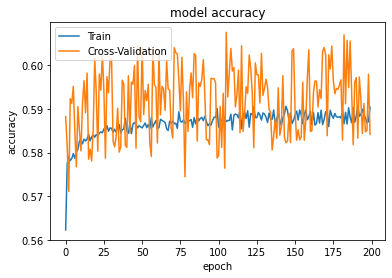

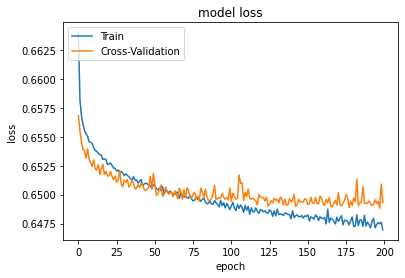

In [18]:
print('Results (lr 0.0001, Adam, relu, 3 hidden layers, 200 epochs):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

## Model Evaluation

In [19]:
# evaluate model

print('Train split:')
loss, accuracy = model.evaluate(norm_train, y_train, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

print('Test split:')
loss, accuracy = model.evaluate(norm_test, y_test, verbose=1)
print('Accuracy: {:5.2f}'.format(accuracy))

Train split:
5038/5038 [==============================] - 16s 3ms/step - loss: 0.6466 - accuracy: 0.5809
Accuracy:  0.58
Test split:
1260/1260 [==============================] - 4s 3ms/step - loss: 0.6493 - accuracy: 0.5842
Accuracy:  0.58


[Text(0, 0.5, 'positive'), Text(0, 1.5, 'negative')]

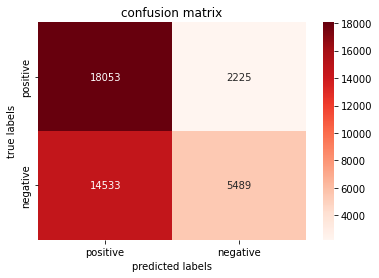

In [21]:
# confusion matrix to see how the model is doing

from sklearn.metrics import confusion_matrix

ax=plt.subplot()
predict_results = model.predict(norm_test)

predict_results = (predict_results > 0.5)
cm = confusion_matrix(y_test, predict_results)

sns.heatmap(cm, annot=True, ax=ax, fmt='d',cmap=plt.cm.Reds)

ax.set_xlabel('predicted labels')
ax.set_ylabel('true labels')
ax.set_title('confusion matrix')
ax.xaxis.set_ticklabels(['positive', 'negative'])
ax.yaxis.set_ticklabels(['positive', 'negative'])

## Hyperparameter Tuning (other tested models)
- tuned parameters: learning rate, optimizer, activation function, number of hidden layers

In [ ]:
print('Results (lr 0.0001, Adam, relu, 1 hidden layer, 50 epochs):')

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Results (lr 0.0001, Adam, relu, 1 hidden layer, 50 epochs):


,loss,accuracy,val_loss,val_accuracy,epoch
45,0.655156,0.583142,0.655096,0.577022,45
46,0.655000,0.581808,0.655025,0.575881,46
47,0.655086,0.580244,0.654795,0.590447,47
48,0.654713,0.580318,0.655010,0.576476,48
49,0.655202,0.581690,0.655231,0.590496,49


Results (lr 0.0001, Adam, relu, 1 hidden layer 50 epochs):


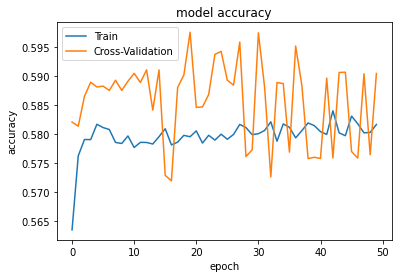

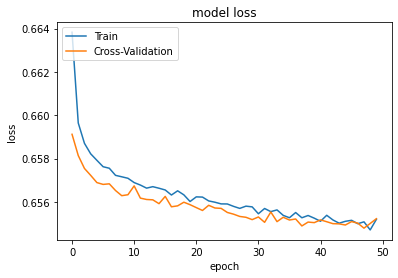

In [ ]:
print('Results (lr 0.0001, Adam, relu, 1 hidden layer 50 epochs):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [ ]:
print('Results (lr 0.0001, Adam, relu, 2 hidden layers, 50 epochs):')

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Results (lr 0.0001, Adam, relu, 2 hidden layers, 50 epochs):


,loss,accuracy,val_loss,val_accuracy,epoch
45,0.652492,0.584259,0.653786,0.584293,45
46,0.652328,0.584594,0.653661,0.579057,46
47,0.652390,0.582794,0.653746,0.598511,47
48,0.652054,0.581820,0.653532,0.580099,48
49,0.652490,0.583527,0.653937,0.598015,49


Results (lr 0.0001, Adam, relu, 2 hidden layers 50 epochs):


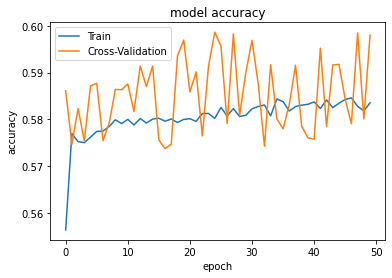

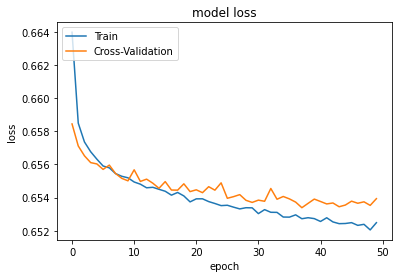

In [ ]:
print('Results (lr 0.0001, Adam, relu, 2 hidden layers 50 epochs):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [ ]:
print('Results (lr 0.0001, Adam, sigmoid, 50 epochs):')

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Results (lr 0.0001, Adam, sigmoid, 50 epochs):


,loss,accuracy,val_loss,val_accuracy,epoch
45,0.657520,0.577079,0.657080,0.591985,45
46,0.657390,0.576564,0.656857,0.571638,46
47,0.657414,0.575571,0.658545,0.592705,47
48,0.657037,0.576160,0.656405,0.571985,48
49,0.657569,0.576030,0.657501,0.592705,49


Results (lr 0.0001, Adam, sigmoid, 50 epochs):


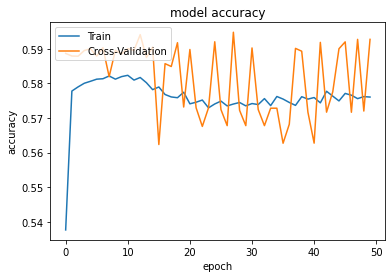

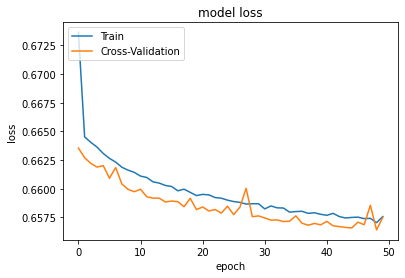

In [ ]:
print('Results (lr 0.0001, Adam, sigmoid, 50 epochs):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [ ]:
print('Results (lr 0.0001, Adam, softmax, 50 epochs):')

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Results (lr 0.0001, Adam, softmax, 50 epochs):


,loss,accuracy,val_loss,val_accuracy,epoch
45,0.659922,0.579611,0.658446,0.585757,45
46,0.659562,0.579418,0.658322,0.585608,46
47,0.659576,0.578847,0.658154,0.585608,47
48,0.659277,0.578494,0.658044,0.585608,48
49,0.659604,0.578605,0.658230,0.592432,49


Results (lr 0.0001, Adam, softmax, 50 epochs):


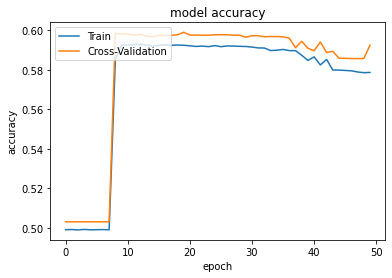

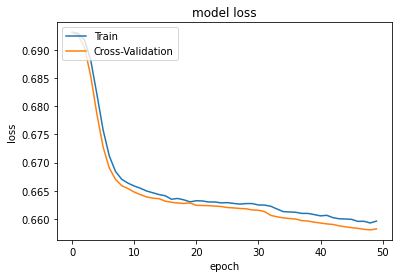

In [ ]:
print('Results (lr 0.0001, Adam, softmax, 50 epochs):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [ ]:
print('Results (lr 0.0001, SGD, relu, 50 epochs):')

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Results (lr 0.0001, SGD, relu, 50 epochs):


,loss,accuracy,val_loss,val_accuracy,epoch
45,0.664003,0.546092,0.662462,0.553102,45
46,0.663725,0.546241,0.662379,0.553102,46
47,0.663777,0.546235,0.662297,0.553102,47
48,0.663528,0.546036,0.662217,0.553102,48
49,0.663788,0.546005,0.662147,0.553102,49


Results (lr 0.0001, SGD, relu, 50 epochs):


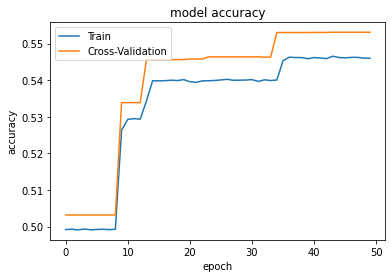

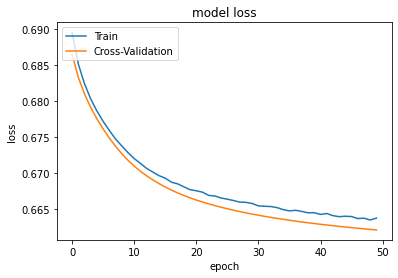

In [ ]:
print('Results (lr 0.0001, SGD, relu, 50 epochs):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [ ]:
print('Results (lr 0.0001, RMSprop, relu, 50 epochs):')

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Results (lr 0.0001, RMSprop, relu, 50 epochs):


,loss,accuracy,val_loss,val_accuracy,epoch
45,0.650969,0.586406,0.652457,0.589603,45
46,0.650845,0.586406,0.652175,0.579330,46
47,0.650917,0.585885,0.652507,0.596402,47
48,0.650451,0.585860,0.652438,0.582754,48
49,0.650966,0.585618,0.651867,0.581762,49


Results (lr 0.0001, RMSprop, relu, 50 epochs):


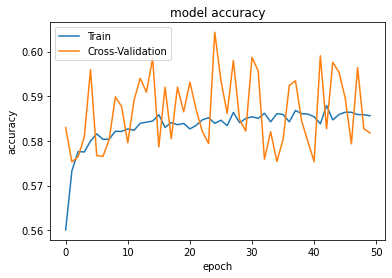

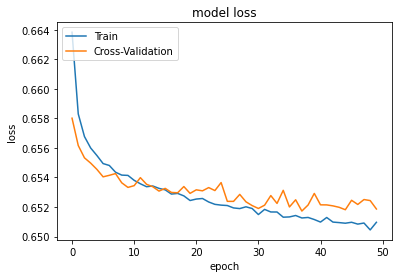

In [ ]:
print('Results (lr 0.0001, RMSprop, relu, 50 epochs):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [ ]:
print('Results (lr 0.0001, Adam, relu, 50 epochs):')

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Results (lr 0.0001, Adam, relu, 50 epochs):


,loss,accuracy,val_loss,val_accuracy,epoch
45,0.650642,0.586555,0.652398,0.588610,45
46,0.650477,0.586785,0.651702,0.581191,46
47,0.650479,0.586096,0.652719,0.597097,47
48,0.650175,0.585165,0.651684,0.593995,48
49,0.650625,0.586146,0.652625,0.603896,49


Results (lr 0.0001, Adam, relu, 50 epochs):


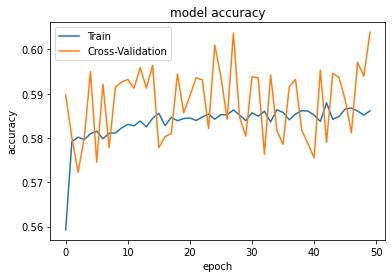

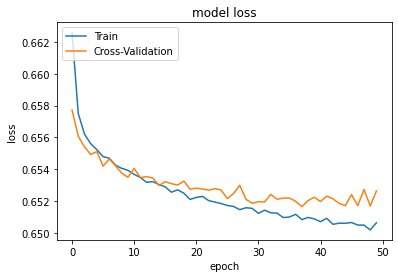

In [ ]:
print('Results (lr 0.0001, Adam, relu, 50 epochs):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [ ]:
print('Results (lr 0.001, Adam, relu, 50 epochs):')

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Results (lr 0.001, Adam, relu, 50 epochs):


,loss,accuracy,val_loss,val_accuracy,epoch
45,0.648653,0.586475,0.651911,0.591687,45
46,0.648449,0.588336,0.650151,0.584119,46
47,0.648441,0.587052,0.651828,0.598834,47
48,0.648377,0.586779,0.650470,0.602506,48
49,0.648652,0.587368,0.651183,0.599305,49


Results (lr 0.001, Adam, relu, 50 epochs):


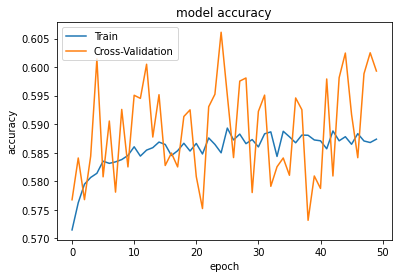

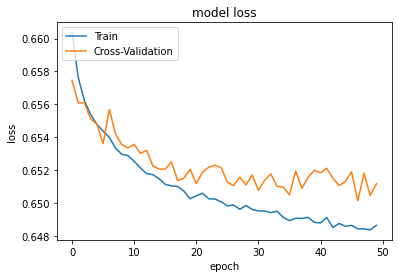

In [ ]:
print('Results (lr 0.001, Adam, relu, 50 epochs):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

In [ ]:
print('Results (lr 0.01, Adam, relu, 50 epochs):')

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Results (lr 0.01, Adam, relu, 50 epochs):


,loss,accuracy,val_loss,val_accuracy,epoch
45,0.671990,0.564263,0.671949,0.601538,45
46,0.672048,0.565560,0.671971,0.503176,46
47,0.671982,0.563655,0.673226,0.601538,47
48,0.671979,0.566144,0.671771,0.503176,48
49,0.672074,0.562203,0.672258,0.601538,49


Results (lr 0.01, Adam, relu, 50 epochs):


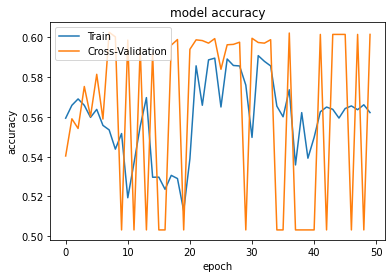

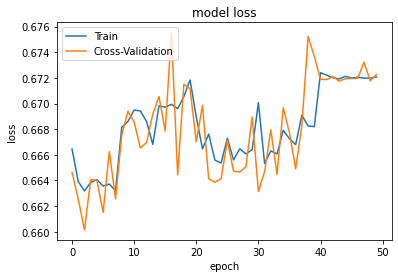

In [ ]:
print('Results (lr 0.01, Adam, relu, 50 epochs):')

# plot test accuracy per epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()

#plot test loss per epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train','Cross-Validation'],loc='upper left')
plt.show()